In [146]:
from pathlib import Path
import torch
import numpy as np
import zuko
import dill
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

rng_seed = 1
# pyro.set_rng_seed(int(rng_seed))
torch.manual_seed(int(rng_seed))
np.random.seed(int(rng_seed))

Text(0, 0.5, 'posterior samples')

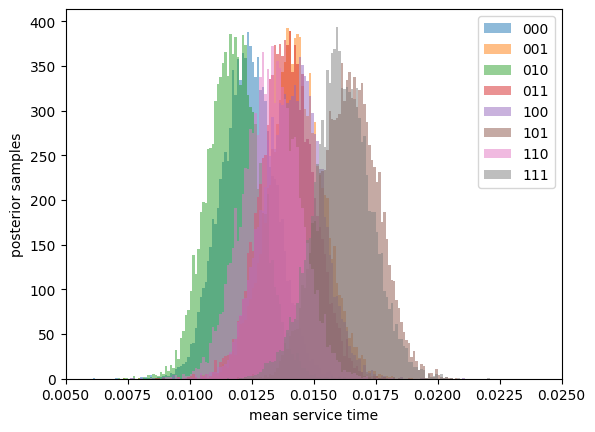

In [147]:
dir_path = Path.cwd()

# /bayes-air-atrds-attempt-8/checkpoints/nsf_730
ckpt_path = dir_path / 'bayes-air-atrds-attempt-8/final/nsf_730/final/output_dict.pkl'

with open(ckpt_path, 'rb') as f:
    output_dict = dill.load(f)

guide = output_dict['guide']

# guide = zuko.flows.NSF(
#     features=1,
#     context=5,
#     hidden_features=(16, 16),
#     bins=4,
# ) #this is the only one that really works??


labels = []
names = []

for y in range(2):
    for x in range(2):
        for w in range(2):
            label = torch.zeros(5, dtype=torch.float)
            label[2*y+x] = 1.0
            label[4] = w
            labels.append(label)
            names.append(f'{y}{x}{w}')

def transform_sample(sample):
    return .004 * sample + .02

n_samples = 10000

fig, ax = plt.subplots()
# for label, color in zip(labels, ['b', 'r']):
bins = np.arange(.0050, .0351, .0001)
for label, name in zip(labels, names):
    # print(label)
    samples = transform_sample(guide(label).sample((n_samples,)))
    ax.hist(
        samples, 
        alpha=.5, 
        fill=True, 
        edgecolor='k', 
        bins=bins,
        linewidth=0,
        label=f'{name}',
    )
    
ax.set_xlim(0.005,.025)
ax.legend()
ax.set_xlabel("mean service time")
ax.set_ylabel("posterior samples")


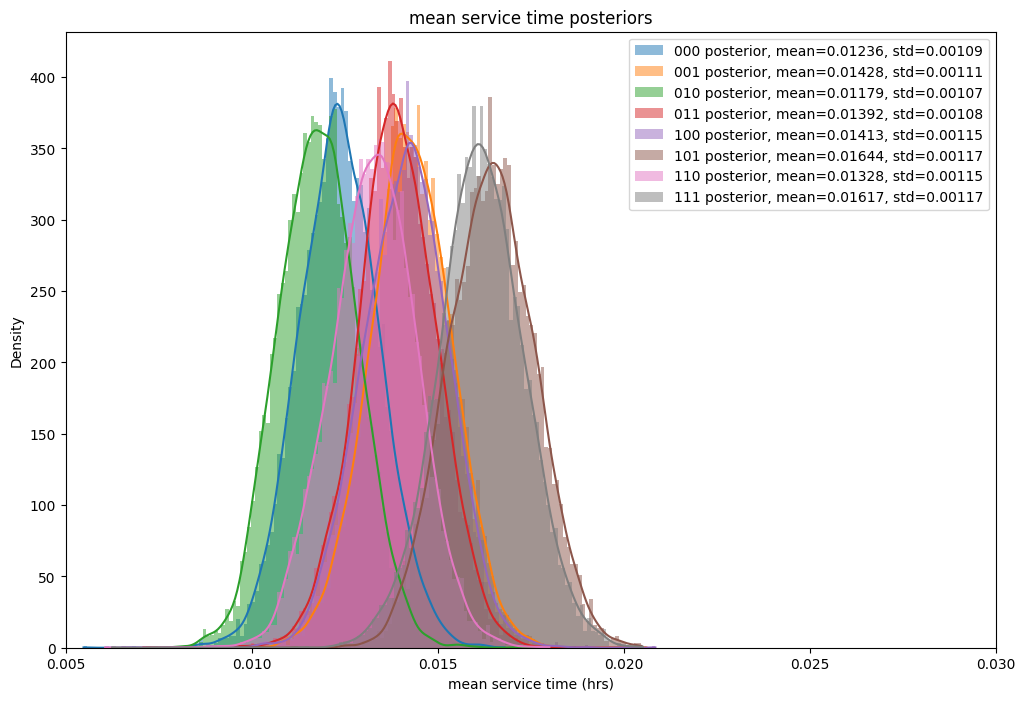

In [148]:
def plot_from_labels_names(guide, labels, names, title=None):

    plotting_df = {}
    samples = {}
    
    for label, name in zip(labels, names):
        samples[name] = transform_sample(guide(label).sample((n_samples,))).squeeze().detach().cpu().numpy()

    groups = samples.keys()

    fig, ax = plt.subplots(figsize=(12, 8))

    for group in groups:
        plotting_df[group] = pd.DataFrame(
            {
                "mean service time (hrs)": samples[group],
                "group": group,
            },
        ) 

    for group in groups:
        
        sns.histplot(
            x="mean service time (hrs)",
            data=plotting_df[group],
            ax=ax,
            binwidth=.0001,
            stat="density",
            # shrink=0.8,
            # hue="group",
            # palette=palette,
            edgecolor='none',
            label=f"{group} posterior, mean={samples[group].mean():.5f}, std={samples[group].std():.5f}",
            kde=True,
        )

    ax.set_xlim(.005, .030)
    ax.set_title("mean service time posteriors" if title is None else title)
    ax.legend()

    return fig

fig = plot_from_labels_names(guide, labels, names)


In [149]:
def label_name_from_yxw(y, x, w):
    label = torch.zeros(5, dtype=torch.float)
    label[2*y+x] = 1.0
    label[4] = w
    name = f'{y}{x}{w}'
    return label, name

def generate_label_name_pairs(on):
    label_pairs = []
    name_pairs = []
    for a in range(2):
        for b in range(2):
            if on == 'y':
                l0, n0 = label_name_from_yxw(0, a, b)
                l1, n1 = label_name_from_yxw(1, a, b)
            elif on == 'x':
                l0, n0 = label_name_from_yxw(a, 0, b)
                l1, n1 = label_name_from_yxw(a, 1, b)
            elif on == 'w':
                l0, n0 = label_name_from_yxw(a, b, 0)
                l1, n1 = label_name_from_yxw(a, b, 1)
            label_pairs.append([l0, l1])
            name_pairs.append([n0, n1])
    return {
        'label_pairs': label_pairs,
        'name_pairs': name_pairs
    }

lnp = {
    on: generate_label_name_pairs(on)
    for on in ('y', 'x', 'w')
}

print(lnp)

def plot_from_labels_names_lnp_entry(guide, on, idx, title=None):
    return plot_from_labels_names(
        guide,
        lnp[on]["label_pairs"][idx], 
        lnp[on]["name_pairs"][idx],
        title,
    )

{'y': {'label_pairs': [[tensor([1., 0., 0., 0., 0.]), tensor([0., 0., 1., 0., 0.])], [tensor([1., 0., 0., 0., 1.]), tensor([0., 0., 1., 0., 1.])], [tensor([0., 1., 0., 0., 0.]), tensor([0., 0., 0., 1., 0.])], [tensor([0., 1., 0., 0., 1.]), tensor([0., 0., 0., 1., 1.])]], 'name_pairs': [['000', '100'], ['001', '101'], ['010', '110'], ['011', '111']]}, 'x': {'label_pairs': [[tensor([1., 0., 0., 0., 0.]), tensor([0., 1., 0., 0., 0.])], [tensor([1., 0., 0., 0., 1.]), tensor([0., 1., 0., 0., 1.])], [tensor([0., 0., 1., 0., 0.]), tensor([0., 0., 0., 1., 0.])], [tensor([0., 0., 1., 0., 1.]), tensor([0., 0., 0., 1., 1.])]], 'name_pairs': [['000', '010'], ['001', '011'], ['100', '110'], ['101', '111']]}, 'w': {'label_pairs': [[tensor([1., 0., 0., 0., 0.]), tensor([1., 0., 0., 0., 1.])], [tensor([0., 1., 0., 0., 0.]), tensor([0., 1., 0., 0., 1.])], [tensor([0., 0., 1., 0., 0.]), tensor([0., 0., 1., 0., 1.])], [tensor([0., 0., 0., 1., 0.]), tensor([0., 0., 0., 1., 1.])]], 'name_pairs': [['000', '

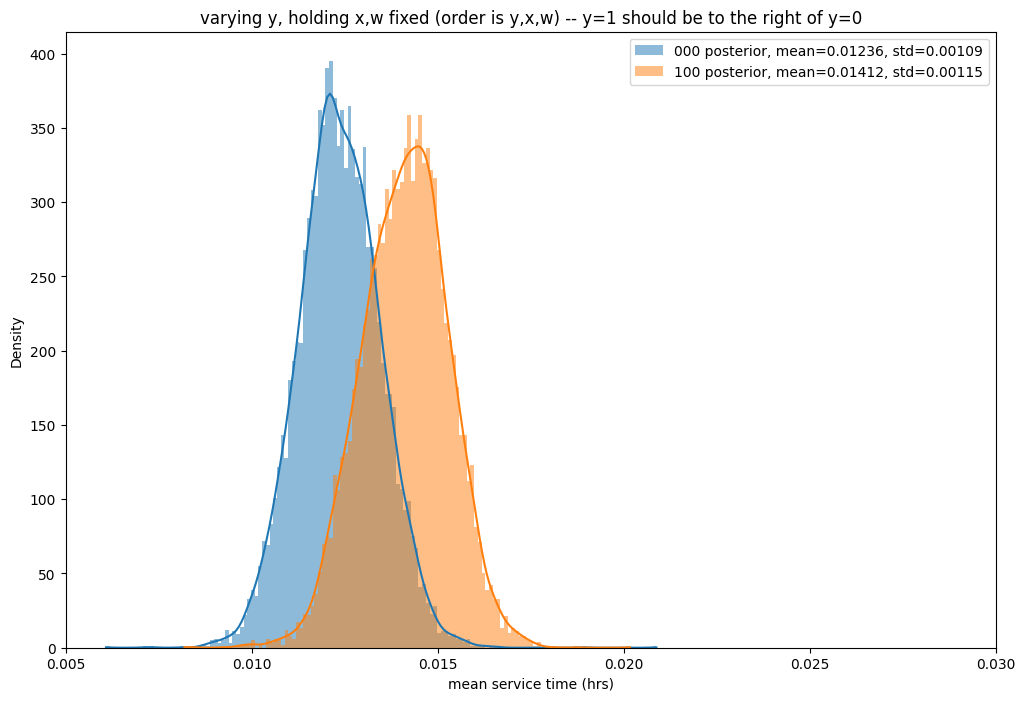

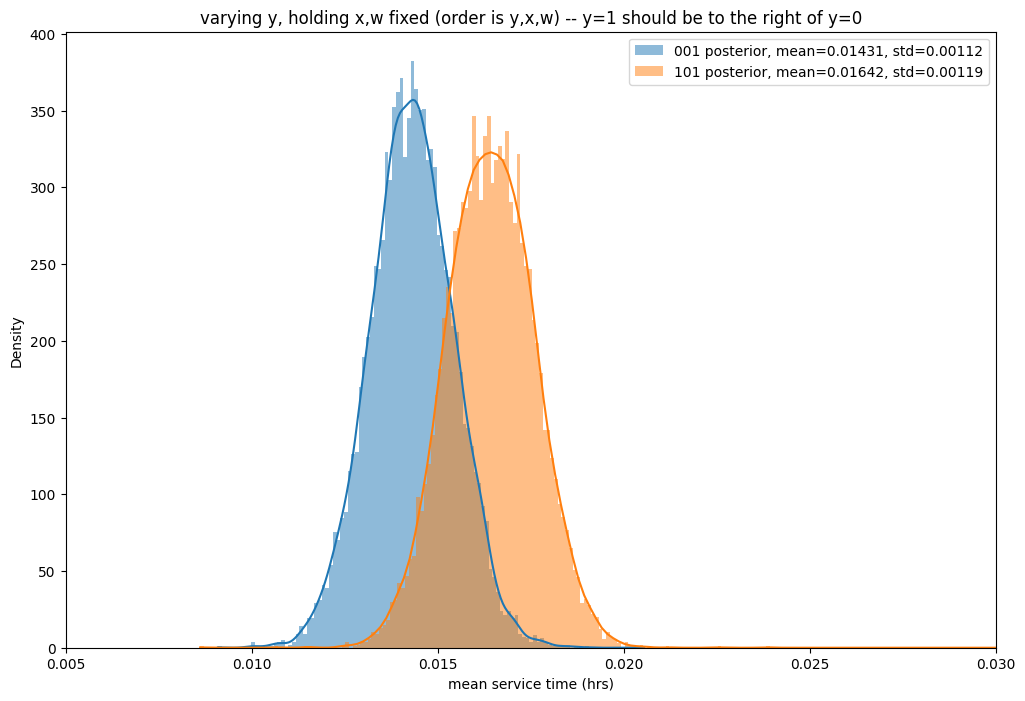

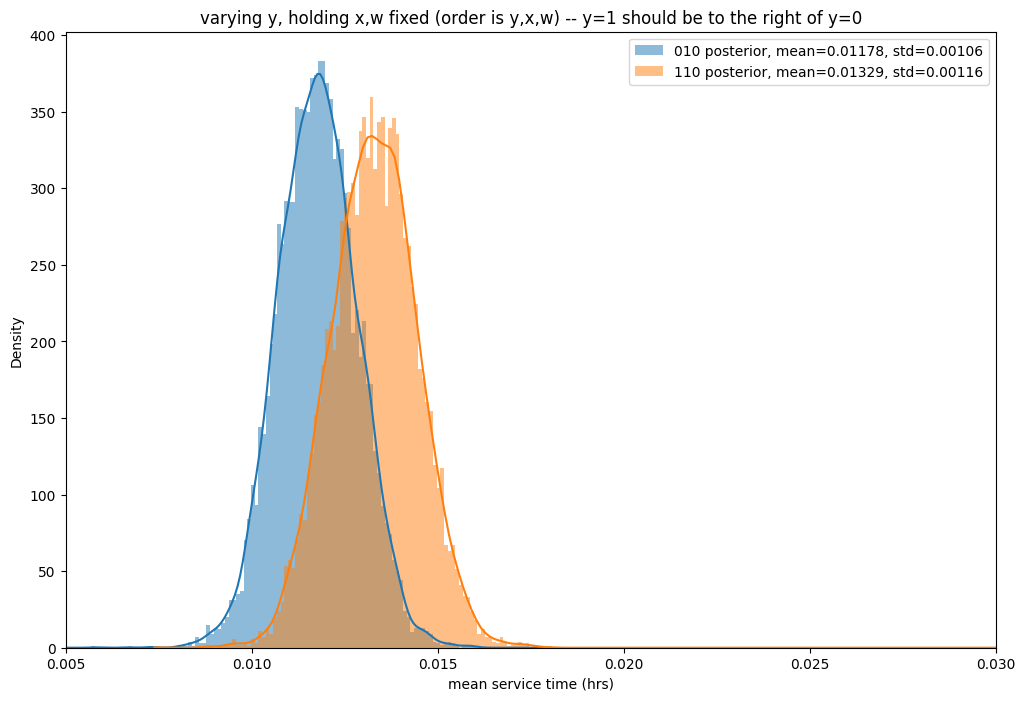

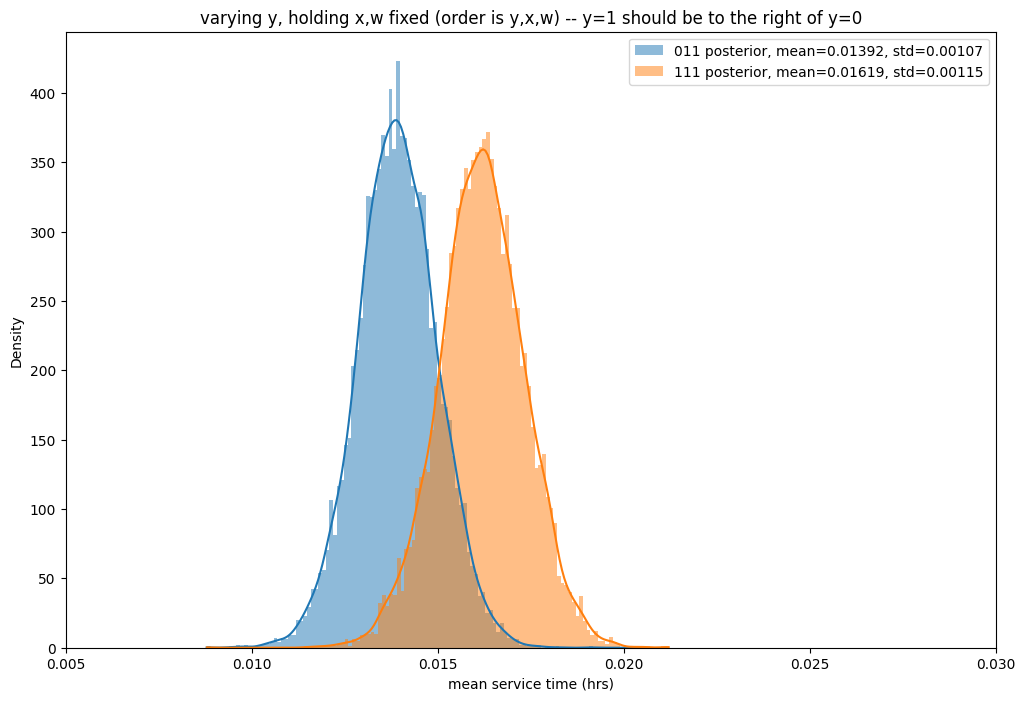

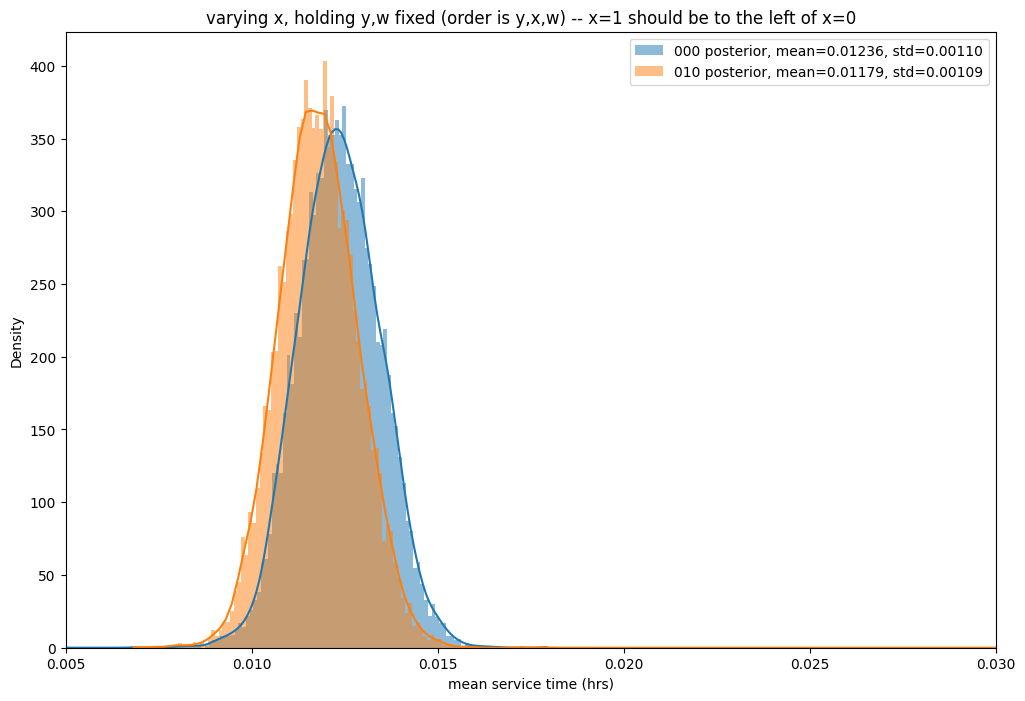

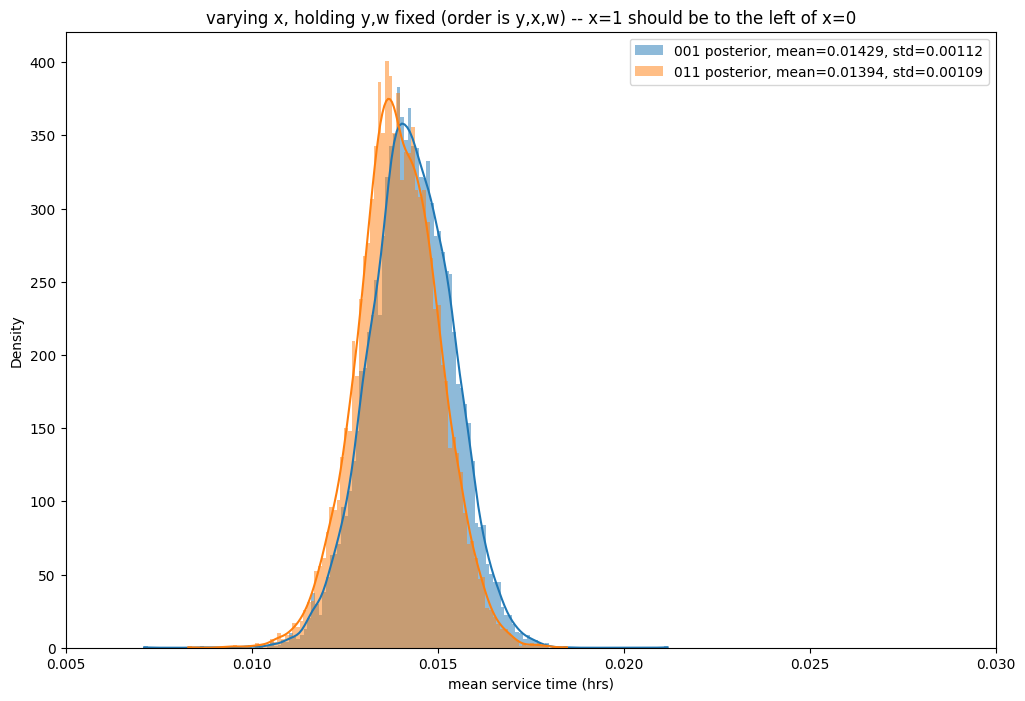

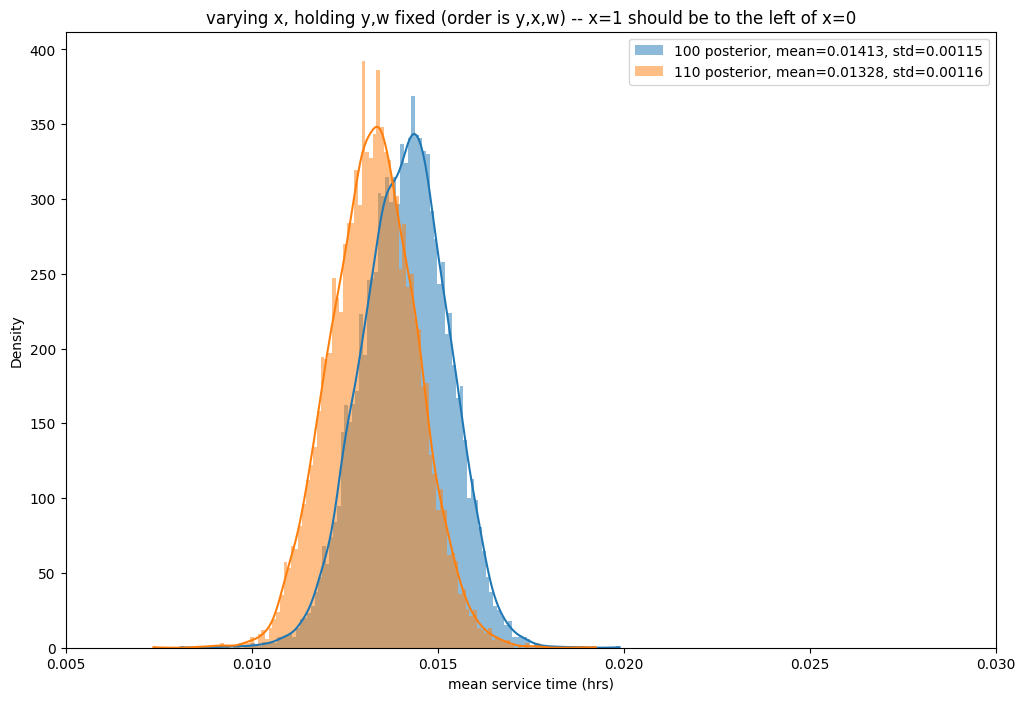

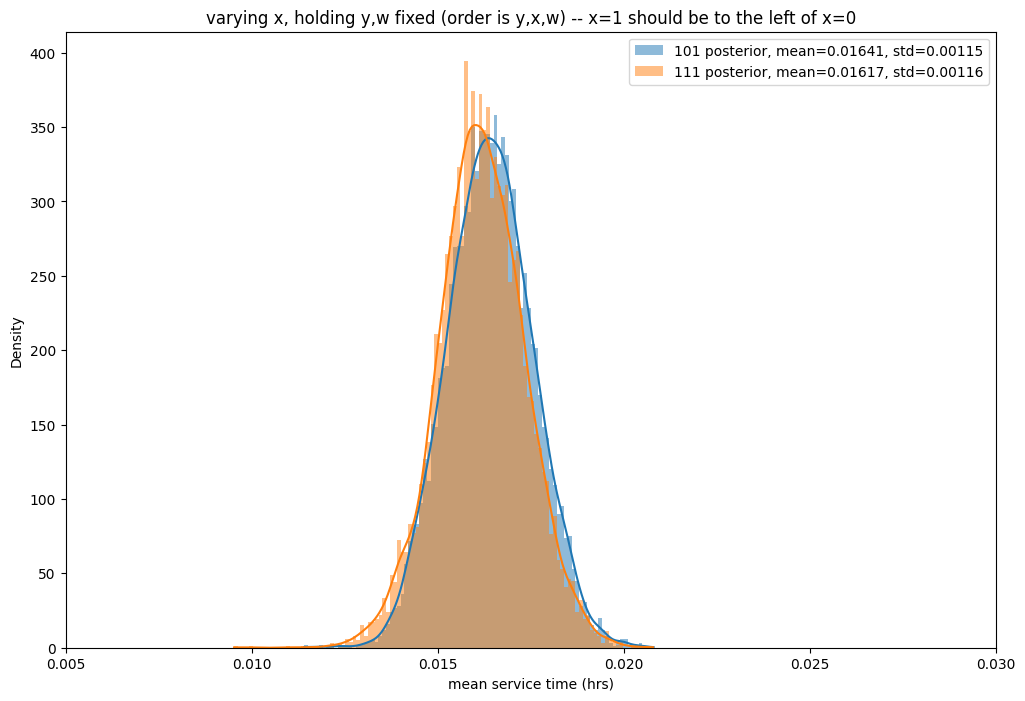

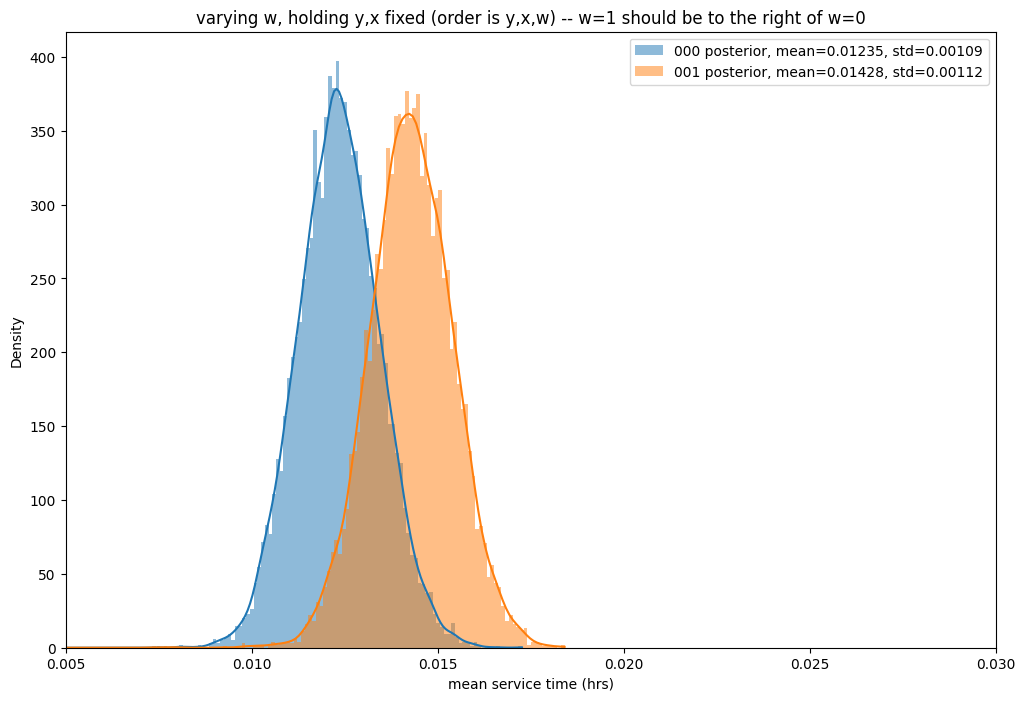

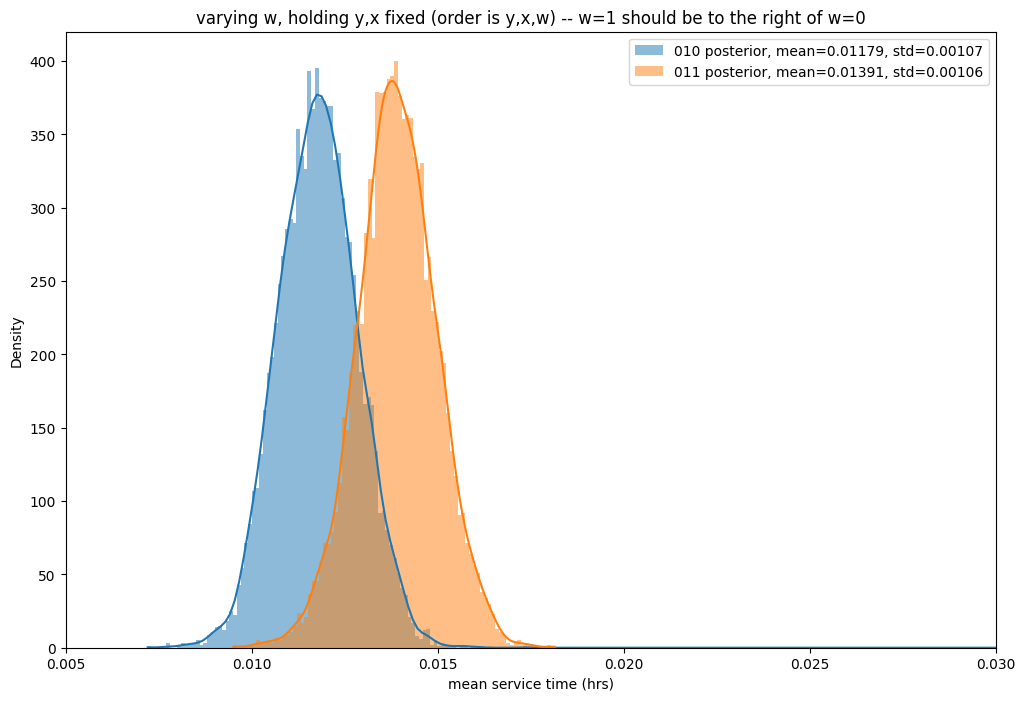

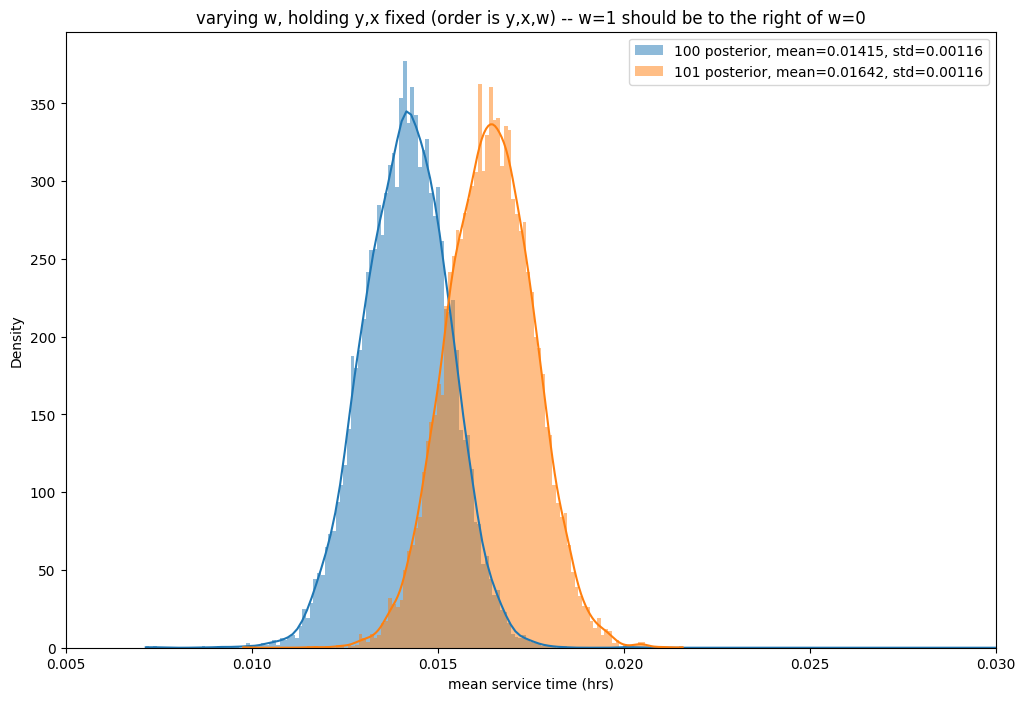

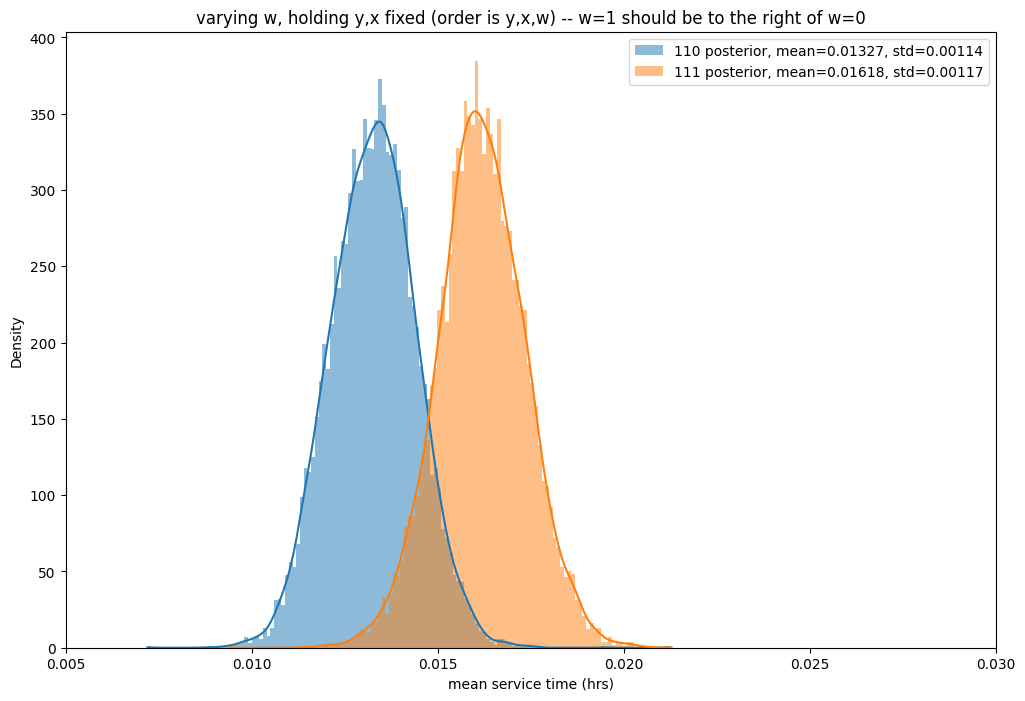

In [150]:
for on in ('y', 'x', 'w'):
    for idx in range(4):
        l = ','.join([a for a in ('y','x','w') if a!=on])
        d = 'left' if on=='x' else 'right'
        fig = plot_from_labels_names_lnp_entry(
            guide,
            on, idx, 
            f'varying {on}, holding {l} fixed (order is y,x,w) -- {on}=1 should be to the {d} of {on}=0'
        )
        plt.show(fig)

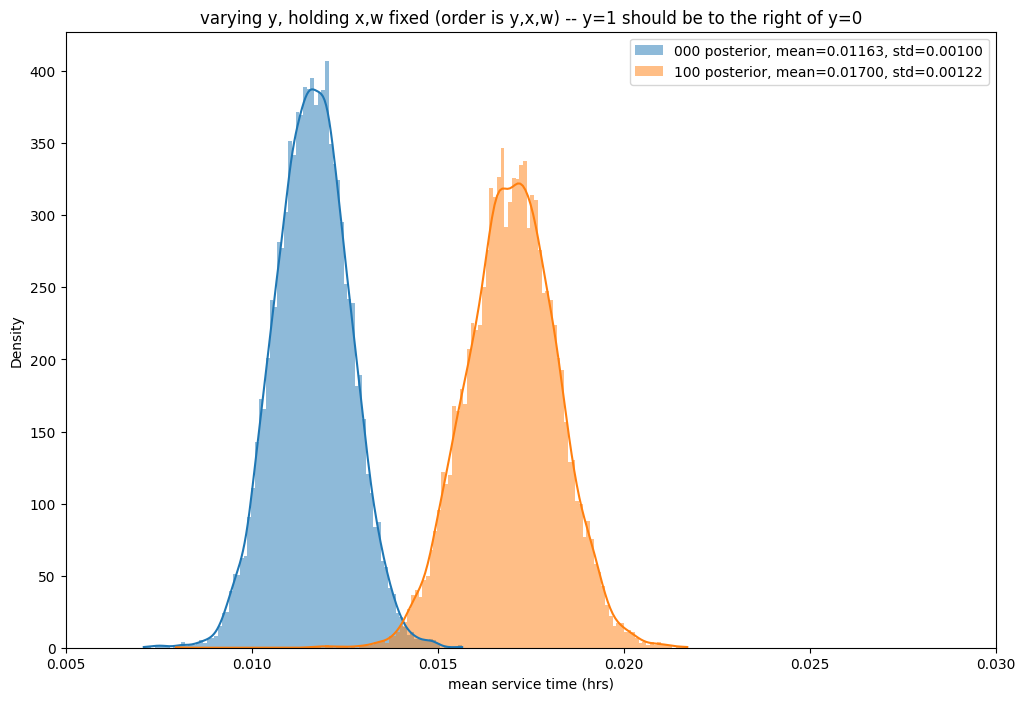

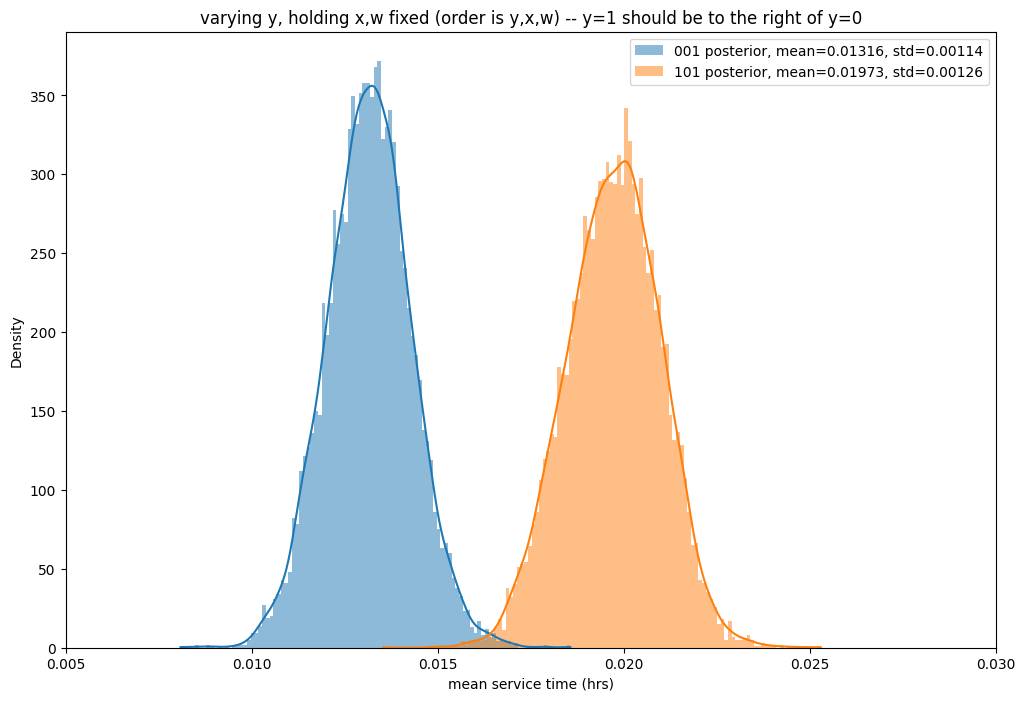

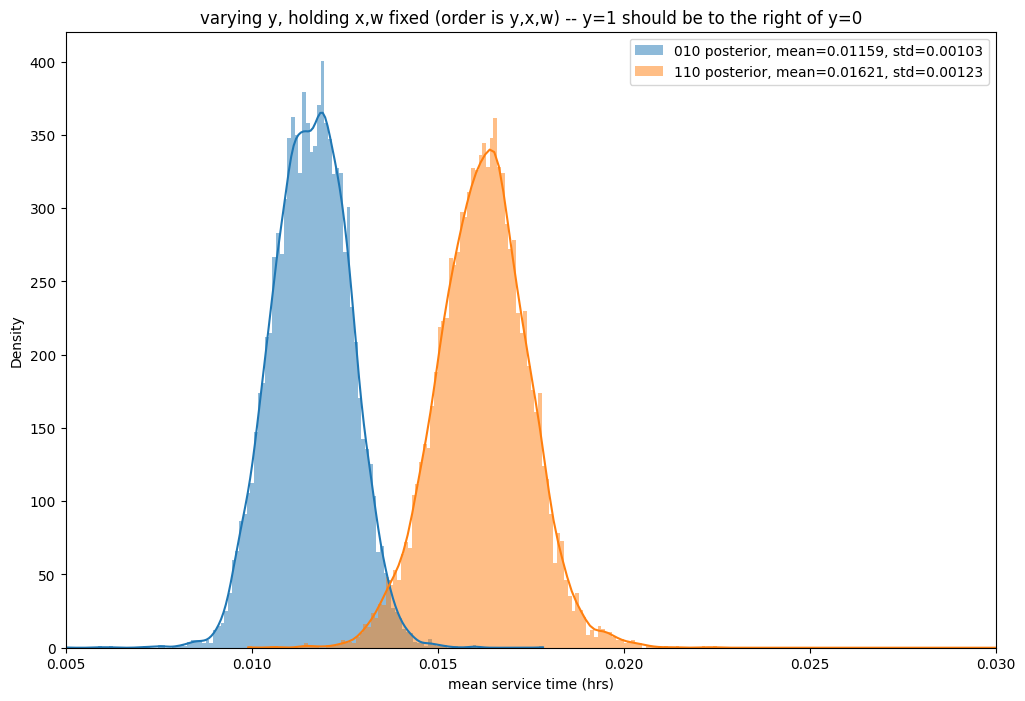

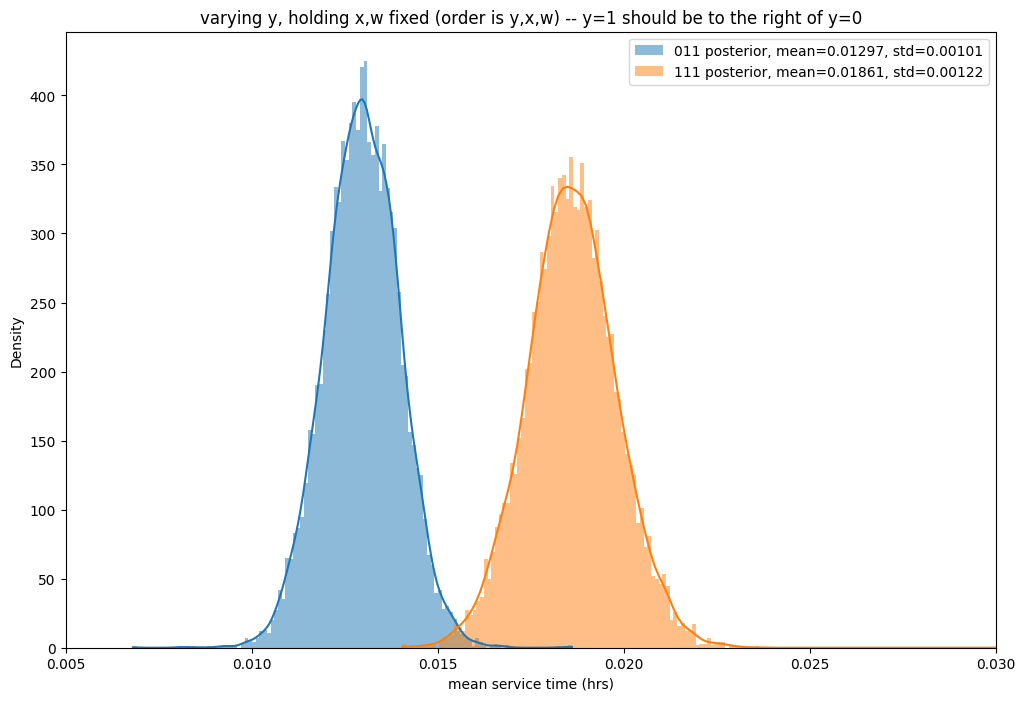

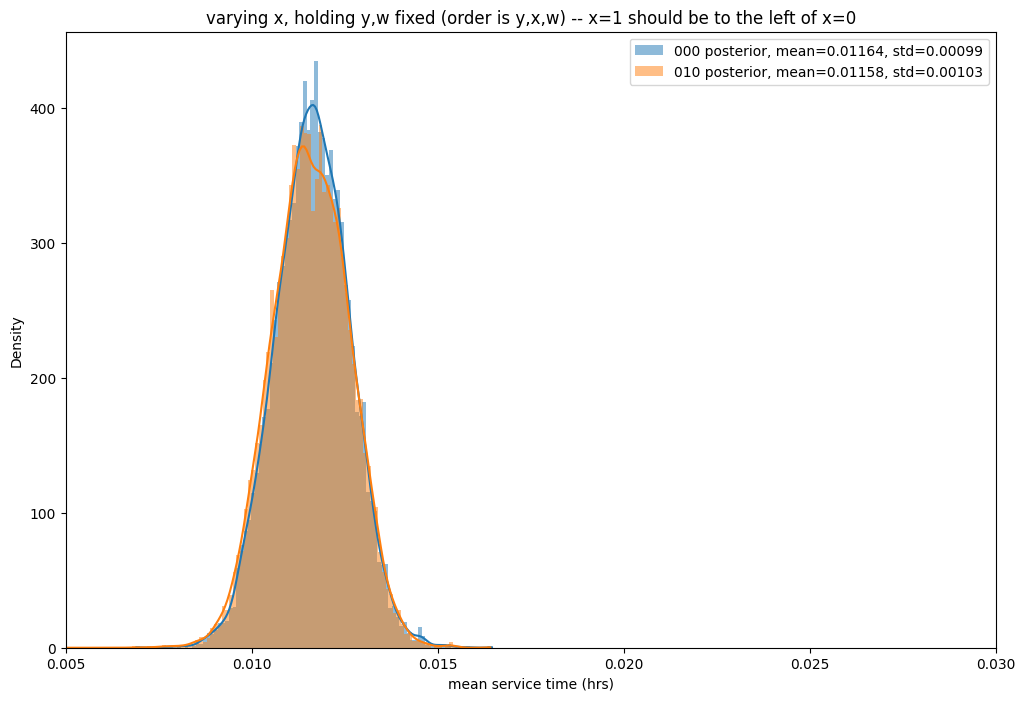

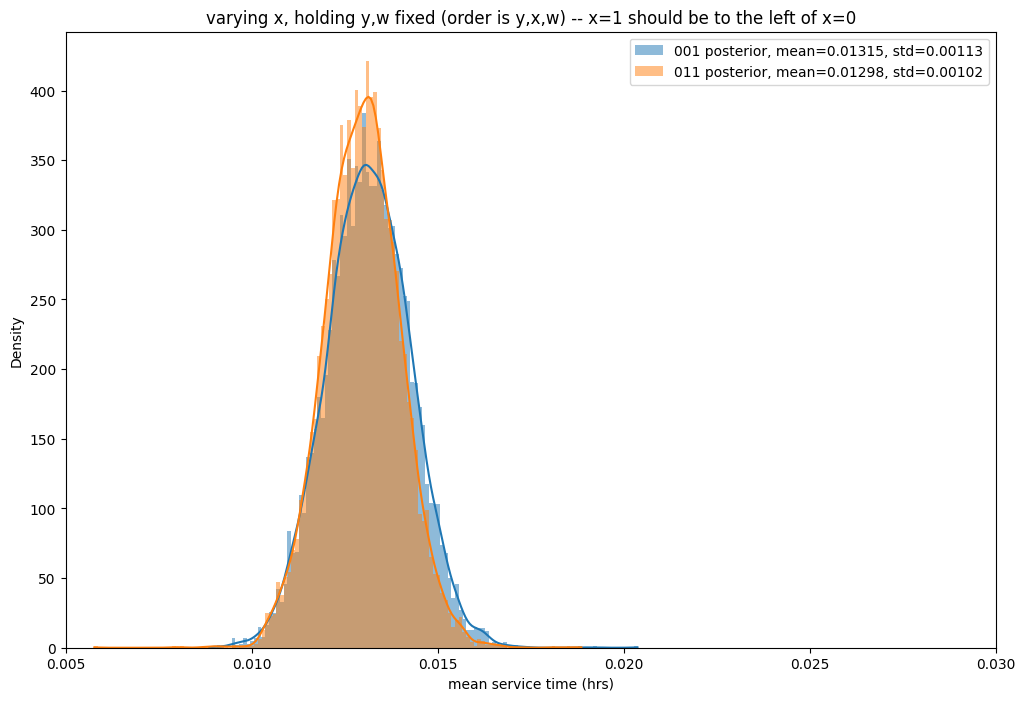

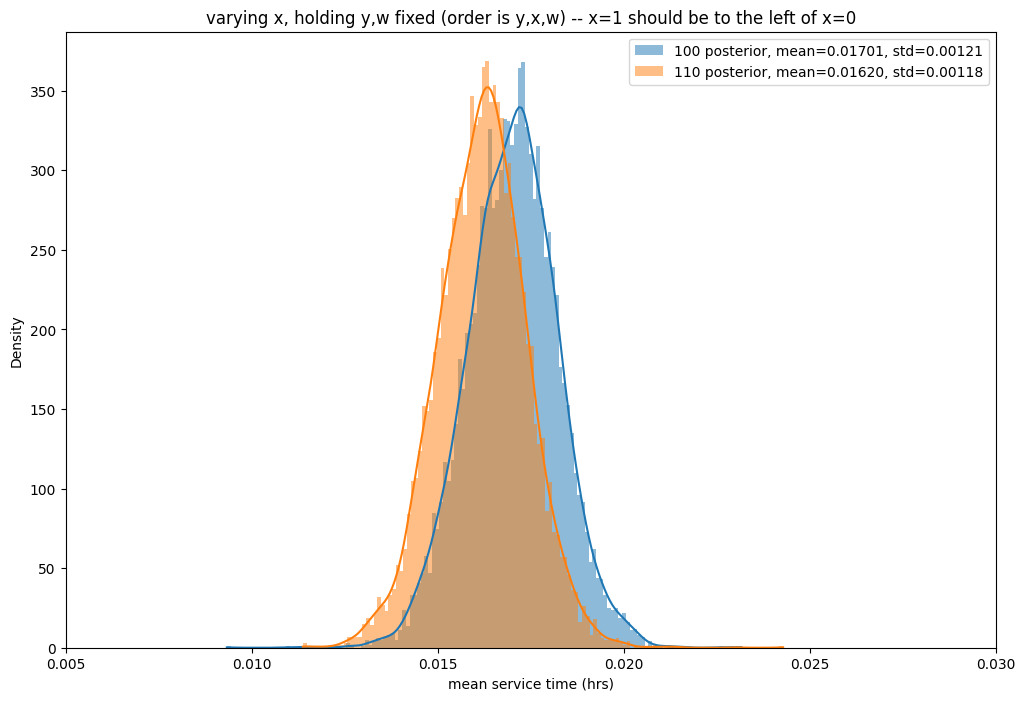

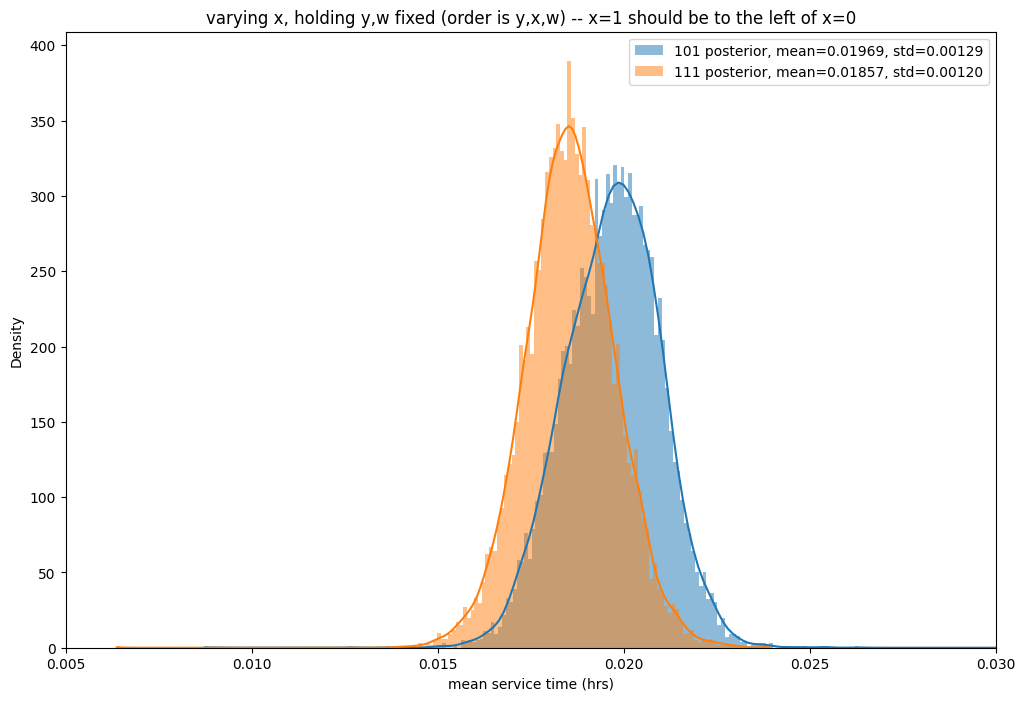

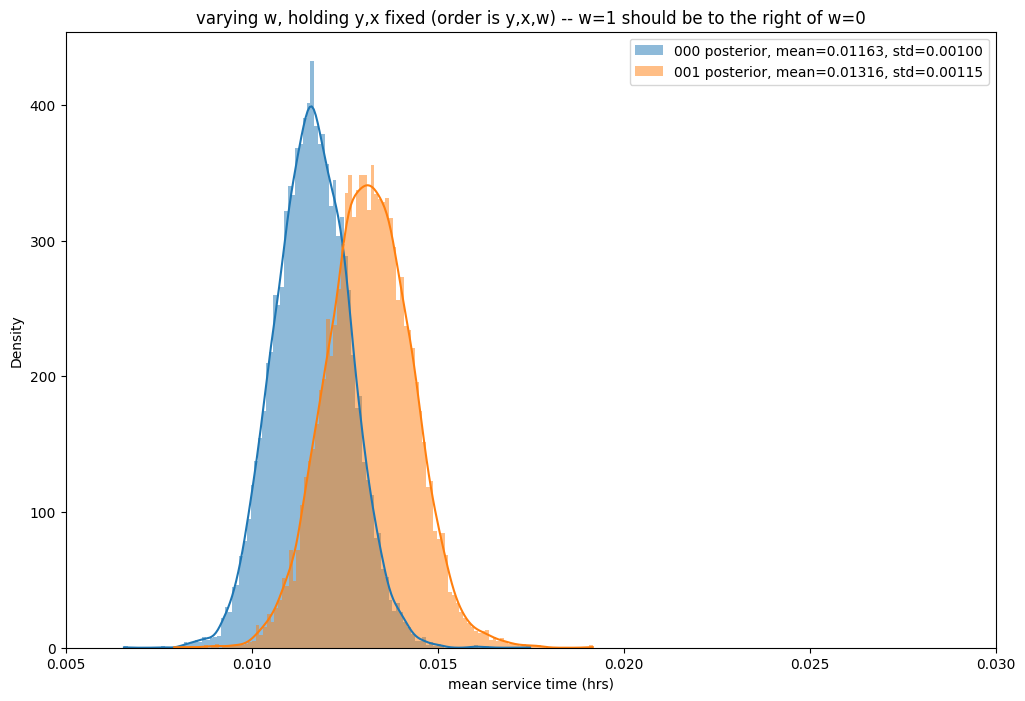

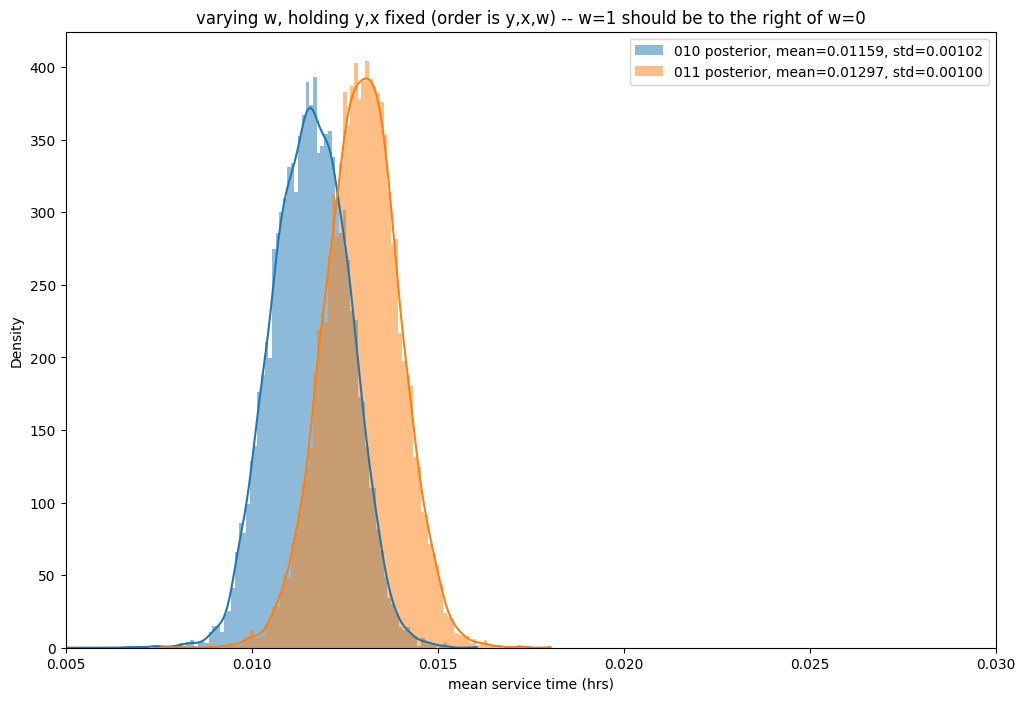

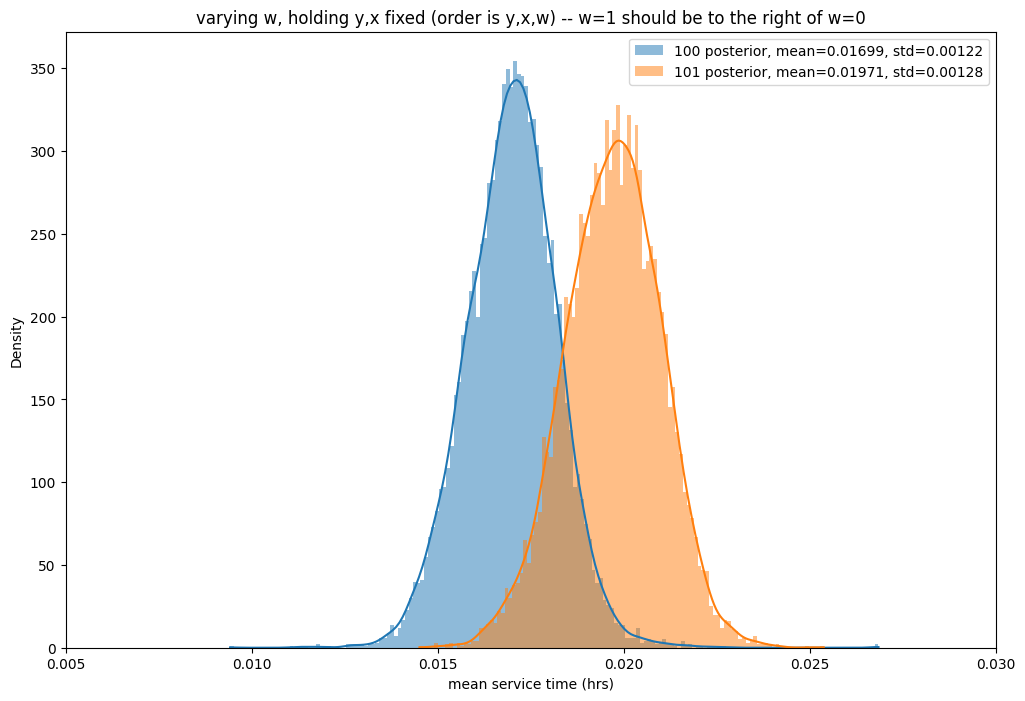

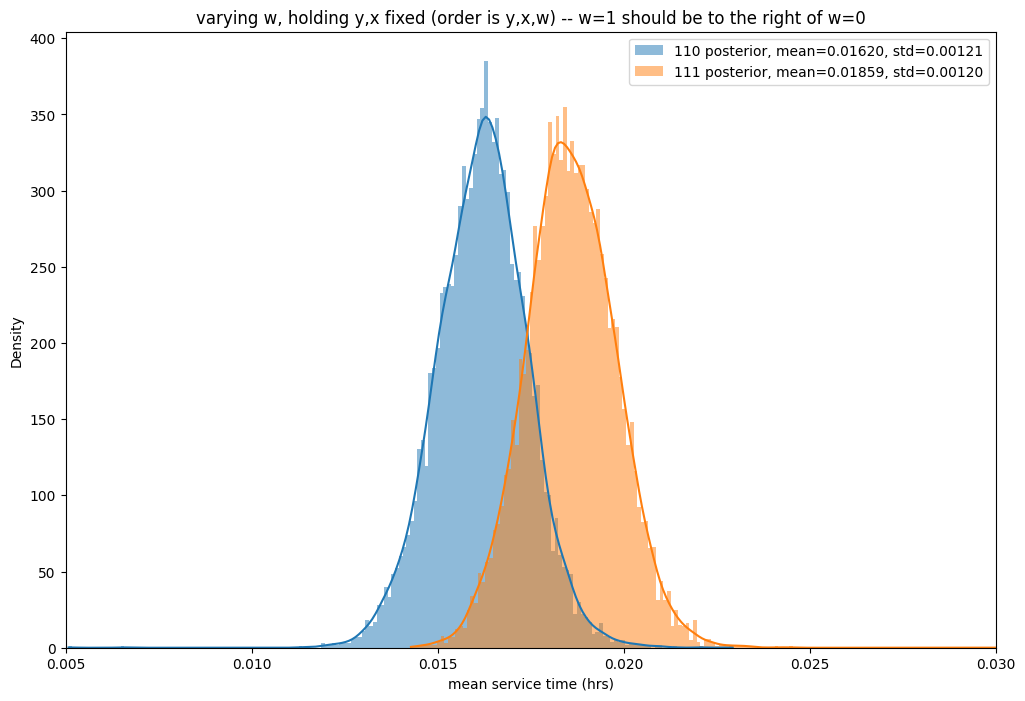

In [151]:
ckpt_path = dir_path / 'bayes-air-atrds-attempt-8/final/nsf_80/final/output_dict.pkl'

with open(ckpt_path, 'rb') as f:
    output_dict = dill.load(f)

guide_80 = output_dict['guide']

for on in ('y', 'x', 'w'):
    for idx in range(4):
        l = ','.join([a for a in ('y','x','w') if a!=on])
        d = 'left' if on=='x' else 'right'
        fig = plot_from_labels_names_lnp_entry(
            guide_80,
            on, idx, 
            f'varying {on}, holding {l} fixed (order is y,x,w) -- {on}=1 should be to the {d} of {on}=0'
        )
        plt.show(fig)